In [1]:
using PyPlot, Printf, DelimitedFiles, Statistics
using CuArrays;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/Pcs5V/src/Revise.jl:1217
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


In [2]:
KBT = KB_kcalpermol*300.0;
K = 16;
spring_constant = 50.0;

In [3]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/string_alad/10_crd_convert/umb.%d.dat" k
  x = readdlm(filename);
  push!(data_k, x)
end

filename = @sprintf "data/string_alad/10_crd_convert/umb_center.dat"
x = readdlm(filename);
umbrella_center =  x;

In [4]:
# data_k = CuArray.(data_k);
# umbrella_center = CuArray(umbrella_center);

In [4]:
data_k

16-element Array{Any,1}:
 [2.332852 2.942286 … 7.59611 1.034719; 2.36353 2.972174 … 7.667831 1.026357; … ; 2.372051 2.987363 … 7.629243 0.99575; 2.278793 3.086819 … 7.632063 1.128406]
 [2.409006 2.664714 … 7.767018 0.90018; 2.39944 2.828521 … 7.756751 0.954941; … ; 2.384777 2.796549 … 7.7285 0.819207; 2.354989 2.809393 … 7.622541 0.978752]
 [2.421438 2.830805 … 7.788936 0.929436; 2.398136 2.761383 … 7.783452 0.859076; … ; 2.370786 2.745588 … 7.766314 0.769158; 2.425431 2.914995 … 7.716807 0.820573]
 [2.474261 2.82763 … 7.773695 0.889101; 2.428653 2.808746 … 7.824356 0.822904; … ; 2.482903 2.718624 … 7.816466 0.812754; 2.457599 2.74526 … 7.858467 0.789756]
 [2.466845 2.81374 … 7.887015 0.589133; 2.501799 2.773517 … 7.847926 0.745526; … ; 2.497062 2.884988 … 7.844658 0.73095; 2.554727 2.800342 … 7.857785 0.837552]
 [2.544888 2.744713 … 7.848381 0.753067; 2.558321 2.730158 … 7.795389 0.791404; … ; 2.511749 2.772269 … 7.830086 0.76363; 2.570823 2.792044 … 7.814648 0.713978]
 [2.558264 2.80

# delta pmf between the umbrella snapshots and the 1st snapshot

In [6]:
@time delta_pmf = sp_delta_pmf(umbrella_center, data_k, KBT, spring_constant);

  3.077728 seconds (10.62 M allocations: 563.045 MiB, 5.99% gc time)


# design matrix for linear regression

delta_pmf = M * weight

In [8]:
sigma_rdf = 0.5;
@time M = sp_design_matrix_atom(umbrella_center, data_k, sigma_rdf);

  0.159419 seconds (60.90 k allocations: 161.937 MiB, 24.55% gc time)


# lasso

Solve weights for 

delta_pmf = M * weight

In [9]:
M_standardized, mean_M, std_M = sp_standardize(M);
delta_pmf_vector = delta_pmf[:] .- mean(delta_pmf);

In [43]:
lambda = 0.1;
#@time weight = sp_admm(delta_pmf_vector, M_standardized, lambda);
@time weight = sp_descent2(delta_pmf_vector, M_standardized, lambda);

[ Cycle Count = 361 ]
[ Complete Condition ]
  Max Differ = 9.861528125404417e-6


  0.127180 seconds (150.32 k allocations: 259.185 MiB, 40.18% gc time)


In [44]:
weight

208-element Array{Float64,1}:
 -0.0
 -0.01567007118736817
  0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.15601701015455363
 -0.0
 -0.164640502548035
  0.3033542351509425
  ⋮
 -0.0
 -0.0
  0.0
 -0.14519579125395388
 -0.0
 -0.050287906791066345
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0

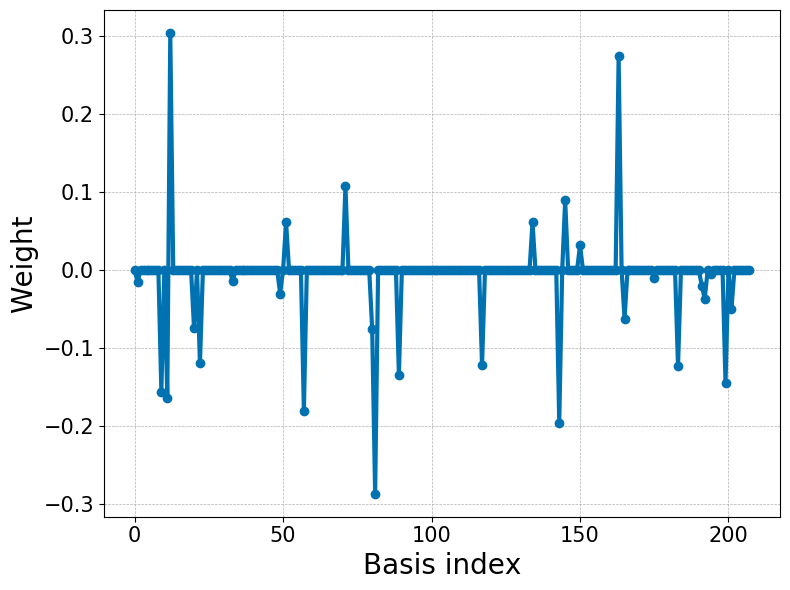

In [45]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(weight[:], linewidth=3, "-o")
xlabel("Basis index",fontsize=20)
ylabel("Weight",fontsize=20)

#ax.set(xlim=[-1, 60], ylim=[-0.3, 0.3])
ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_weight.png", dpi=350)

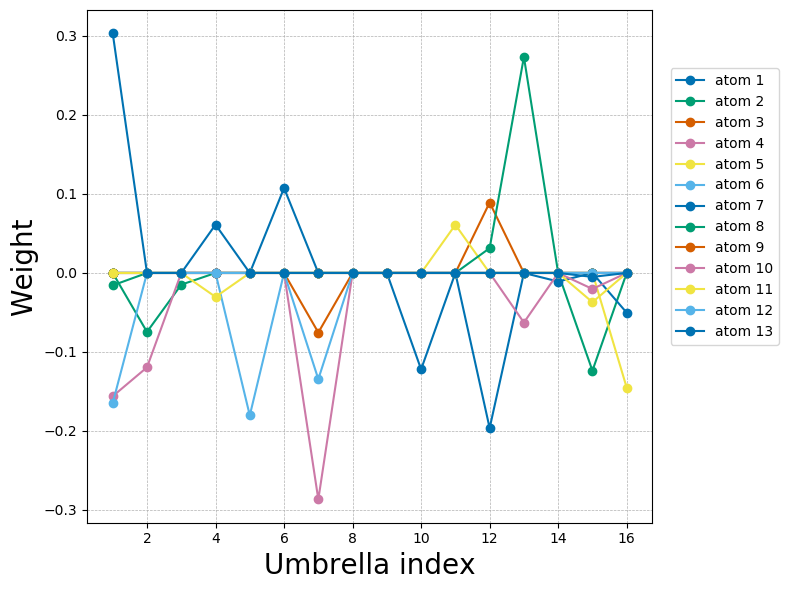

In [46]:
natom = Int(size(umbrella_center, 2) / 3)
weight_atom = reshape(weight, natom, K)'

fig, ax = subplots(figsize=(8, 6))
for iatom = 1:natom
    ax.plot(1:K, weight_atom[:, iatom], "-o", label=@sprintf "atom %d" iatom)
end
plt.xlabel("Umbrella index", fontsize=20)
plt.ylabel("Weight", fontsize=20)
plt.legend(loc="uppper right", bbox_to_anchor=(1.02, 0.9))

ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#c = get_cmap("viridis")
#c = get_cmap("tab20")

#savefig("lasso_along_path_weight_atom.png", dpi=350)

# cumulate PMF

In [47]:
pmf = sp_cumulate_pmf_atom(umbrella_center, weight, umbrella_center, sigma_rdf, mean_M, std_M)

16-element Array{Float64,1}:
  1.6821001665258706
  0.0
  2.631301336723464
  5.334398050331195
  7.119174257856415
  7.198394771656083
  7.087258819931929
  7.414198654993964
  7.905937642232065
  9.468145634910087
 11.095337762314124
 11.972831918952066
 11.365223440984671
  9.524977808170327
  7.760301804282673
  7.510731053847053

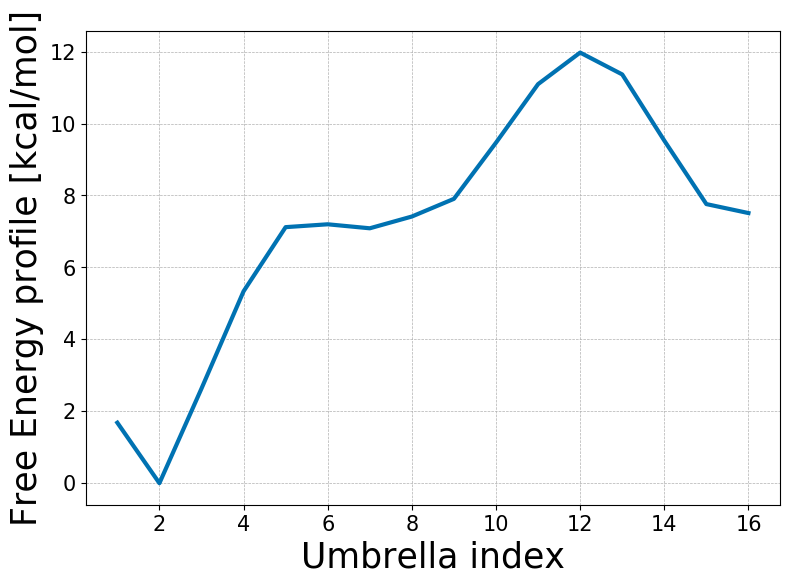

In [48]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(1:K, pmf, linewidth=3)
xlabel("Umbrella index",fontsize=25)
ylabel("Free Energy profile [kcal/mol]",fontsize=25)

ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_pmf..png", dpi=350)